In [1]:
from ensembles import VanillaEnsemble
from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction, train_and_plot, plot_error
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 4]
from evaluation import evaluate_model
import tensorflow as tf

from tqdm import tqdm


# Explanation



Showing the efficiency of two estimators, comparing to a vanialla Neural Network.

All Estimators are built in tensorflow (1.4 [*]) and are based on the same parent object (ToDo: Make this more beautiful and readable). Code can be found in /estimators.

GaussianLossEstimator [1], in which $\mu$ and $\sigma^2$ are estimated directly by using a gaussian cost function $-1/2 ln [\sigma^2(x_i)] - \frac{[y-\hat{y}]^2}{2\sigma^2(x_i)} $. In practice, this means separate output nodes have been added for both mean and variance, with corrensponding final layers. To ensure positive $\sigma^2$, a softmax function is applied according to [2]. The derivatives used for the backwards pass update can be found in [1], thanks to Tensorflows Automatic Differentiation, the author was spared implementing a working function of this [4].

GaussianLearningRateEstimator, which is a GaussianLossEstimator in which the predicted $\sigma$ is used to scale the learning rate for each sample. This approach hasn't been found in a [arguable somewhat shallow] literature review. It's too early to claim novelty, but it is fun to work with!

For both models, a minimum variance is returned if the variance goes below a certain threshold to (try to) avoid numerical instabilities


No Regularisation has been added, thus quite a bit of overfitting occurs.







# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), so no distribution over parameters


# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is on-line, i.e. each sample is fed into the network on a singular basis (Stochastic gradient descent with batch size 1)

The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list)


# Problems/ToDo
Weirdly, the standard GaussianLossEstimator tends to fall into numerical instabilities (see e.g. seed #forgottowritedowntheseedandIfeelbad (1011???))

Overfitting is locally SEVERE sometimes (e.g. seed 43). Why.

Adding SOME Regularisation might be cool: The learning rate thing looks like a perfect fit for early stopping

Hyperparameters need to be tuned

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)

Learningrate scaling in GaussianLearningRateEstimator is absolutely eyeballed and not based on any evidence at all except for the fact that 'I've seeb people use square roots in combination with the standard deviation/variance'.


Implement Dropout Estimator from [3] and give it the whole routine




# Sources

[1] Nix, D. A., & Weigend, A. S. (1994, June). Estimating the mean and variance of the target probability distribution. In Neural Networks, 1994. IEEE World Congress on Computational Intelligence., 1994 IEEE International Conference On (Vol. 1, pp. 55-60). IEEE.
Chicago	
Link: http://ieeexplore.ieee.org/abstract/document/374138/


[2] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474

[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html

[4] Huxley, Aldous. Brave New World. New York: Harper Brothers, 1932. Print. 


[*] BIG shoutout to https://danijar.com/structuring-your-tensorflow-models/ for helping me understand how to use Tensorflow in an object oriented manner


# Preparations

In [2]:
num_epochs = 10
num_eps = 25#75
#seed = 43#43 is cool 101 1011
from global_vars import SEED as seed

params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}
          #'optimizer':tf.train.AdamOptimizer}


In [3]:

data = make_dataset(train_p=0.8,seed=seed)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

In [4]:
#X_test[:10],X[:10]

In [5]:
#len(X), len(sorted_index),len(data['test_ind']),len(X_test)

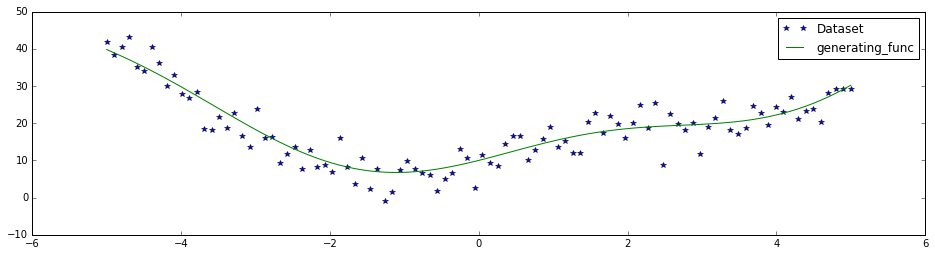

In [6]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# initialise Networks

In [7]:
from estimators import GaussianLossEstimator,GaussianLearningRateEstimator, EnsembleNetwork

gauss = GaussianLossEstimator(**params)
gauss_lr = GaussianLearningRateEstimator(**params)
vanilla = EnsembleNetwork(**params)

In [8]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)


lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

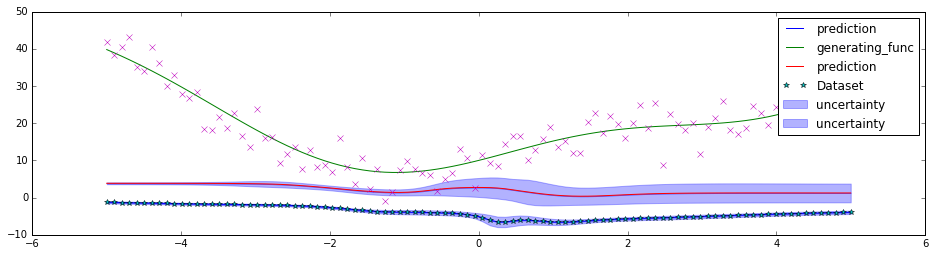

In [9]:
plot_prediction(X,
                gauss_preds,
                sorted_index,
                gauss_var,
                generating_func=generate_sinoid)
plot_prediction(X,
                lr_preds,
                sorted_index,
                lr_var)
plot_prediction(X,vanilla_preds,sorted_index)
plt.plot(X,y,'x')

In [10]:
evaluate_model(X,y,gauss_preds)

RSME is 23.884370803833008


In [11]:
evaluate_model(X,y,lr_preds)

RSME is 18.52665901184082


In [12]:
evaluate_model(X,y,vanilla_preds)

RSME is 23.884370803833008


# Training


## GaussianLossEstimator

Maye replace min_variance with 

In [13]:
num_eps

25

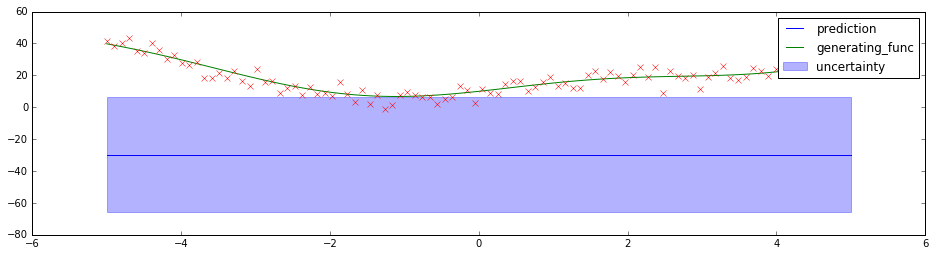

RSME is 48.68015670776367
COVERAGE PROBABILITY is 0.08
MEAN VARIANCE is 35.885498046875
COVERAGE/MEAN_VAR is 0.002229312796369747
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.0065640267, 0.94832074471747285)


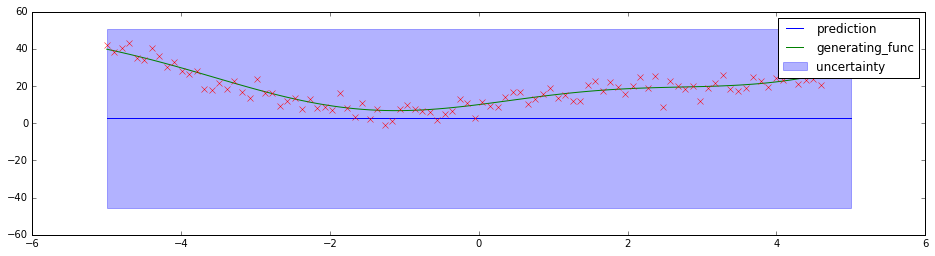

RSME is 18.18347930908203
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 48.07095718383789
COVERAGE/MEAN_VAR is 0.020802581404312324
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.036392238, 0.71924644367001878)


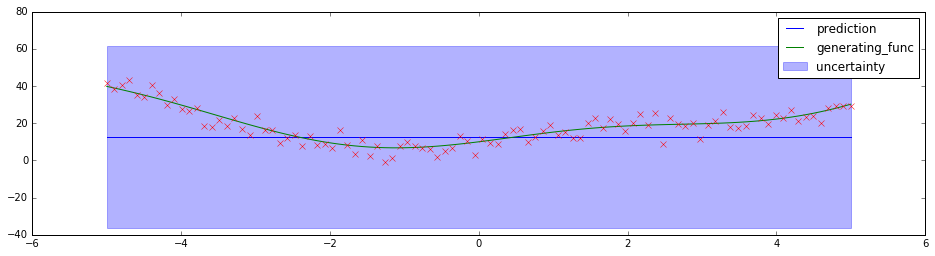

RSME is 11.067337036132812
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 49.081817626953125
COVERAGE/MEAN_VAR is 0.02037414359020912
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.0062098228, 0.95110589034902115)


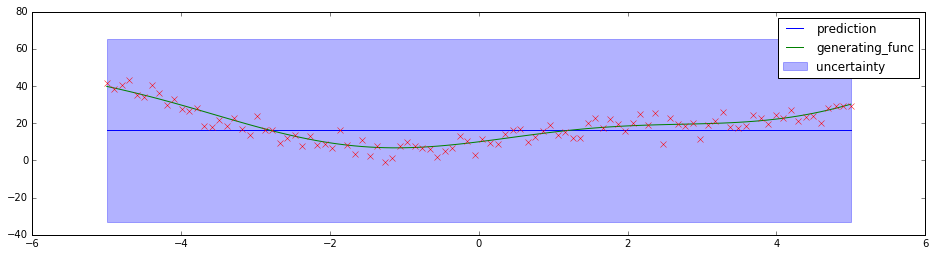

RSME is 9.788607597351074
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 49.150569915771484
COVERAGE/MEAN_VAR is 0.020345644042656746
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (-0.02974006, 0.7689668941609924)


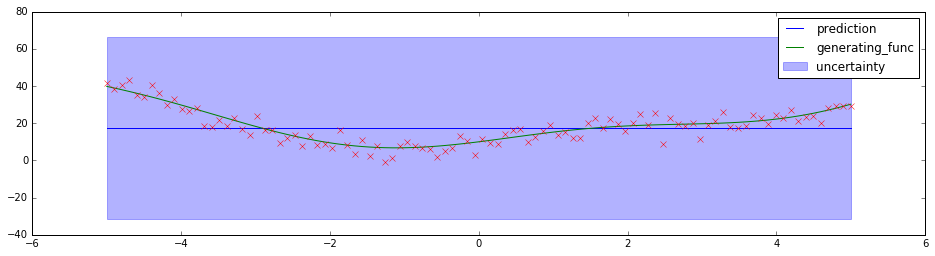

RSME is 9.60942268371582
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 49.101409912109375
COVERAGE/MEAN_VAR is 0.02036601396558636
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.0066590607, 0.94757358569681249)


In [14]:
errors = train_and_plot(gauss,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

In [15]:
#plot_error(errors)

gauss_error_list = []
#for i in tqdm(range(num_eps)):
for i in range(num_eps):
    #gauss.train(X,y)
    errors = gauss.train_and_evaluate(X,y)
    gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        gauss_preds = gauss.predict(X)
        gauss_var = gauss.predict_var(X)

        #lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)
#plt.show()

## GaussianLearningRateEstimator

gauss_lr_error_list = []
for i in range(num_eps):
    errors = gauss_lr.train_and_evaluate(X,y)
    gauss_lr_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        gauss_preds = gauss_lr.predict(X)
        gauss_var = gauss_lr.predict_var(X)

        #3lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)

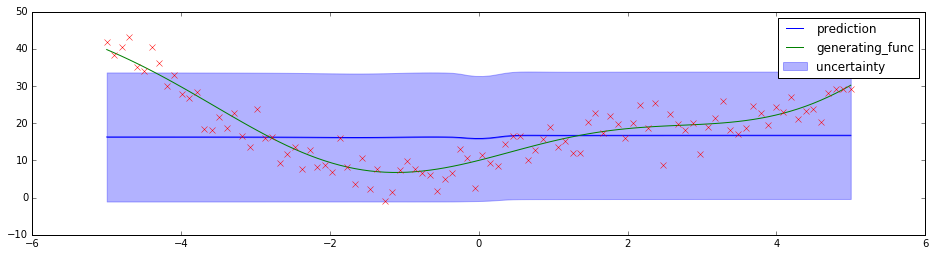

RSME is 9.648370742797852
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 17.192476272583008
COVERAGE/MEAN_VAR is 0.053511779537374266
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.40422964, 3.0336174366773989e-05)


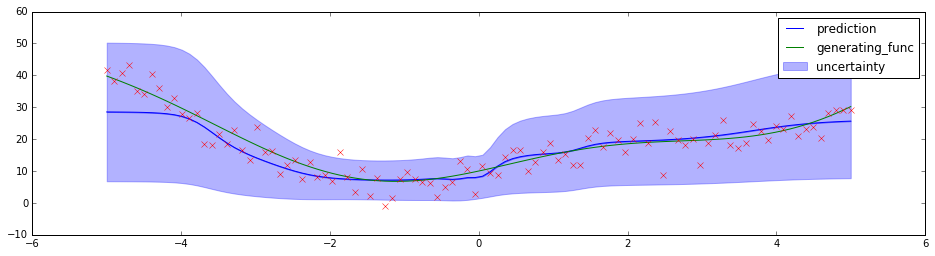

RSME is 4.664953231811523
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 13.103842735290527
COVERAGE/MEAN_VAR is 0.07478722232835712
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.35360646, 0.0003074573755320999)


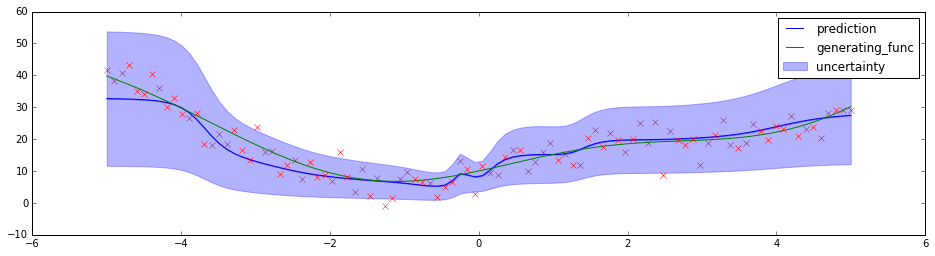

RSME is 3.9959723949432373
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 10.792489051818848
COVERAGE/MEAN_VAR is 0.08802418009772243
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.2074271, 0.038380143782939982)


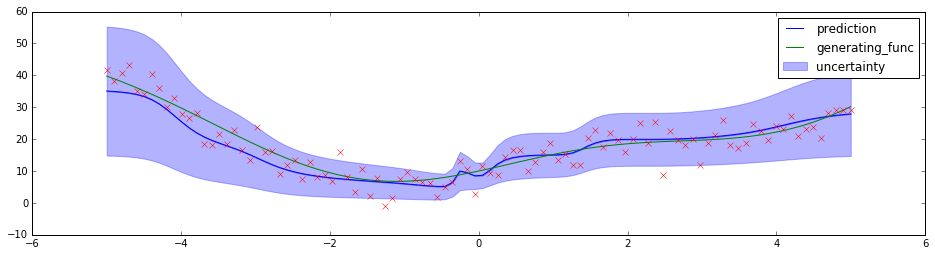

RSME is 3.805382251739502
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 9.315345764160156
COVERAGE/MEAN_VAR is 0.10090876106999208
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.18044612, 0.072406670725810876)


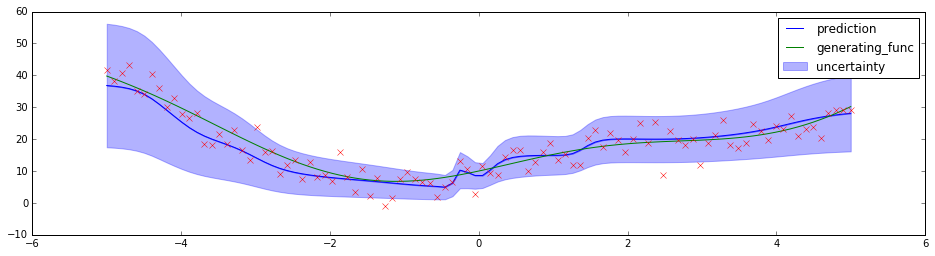

RSME is 3.705888271331787
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 8.568172454833984
COVERAGE/MEAN_VAR is 0.1085412326727053
CORRELATION BETWEEN UNCERTAINTY AND ERROR IS (0.10304411, 0.30763141886386536)


In [16]:
errors = train_and_plot(gauss_lr,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

In [17]:
#plot_error(errors)

## Vanilla Neural Network for comparisson

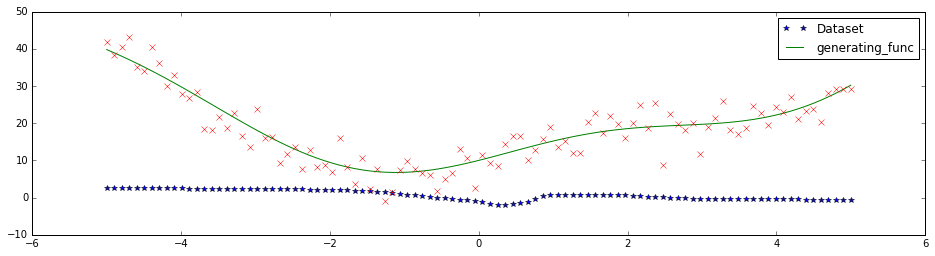

RSME is 19.727157592773438


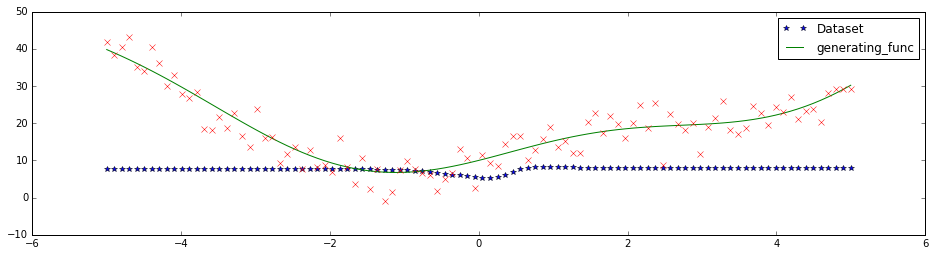

RSME is 14.018795013427734


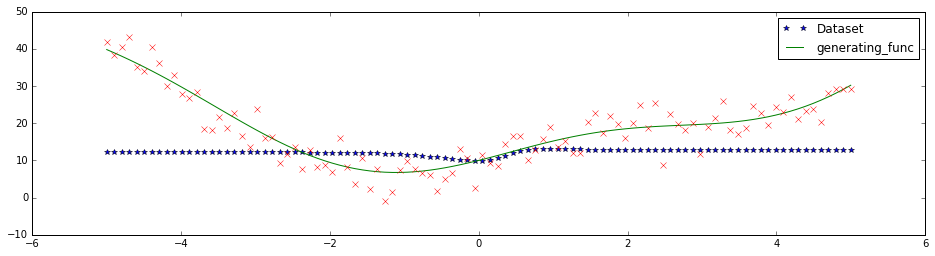

RSME is 10.972301483154297


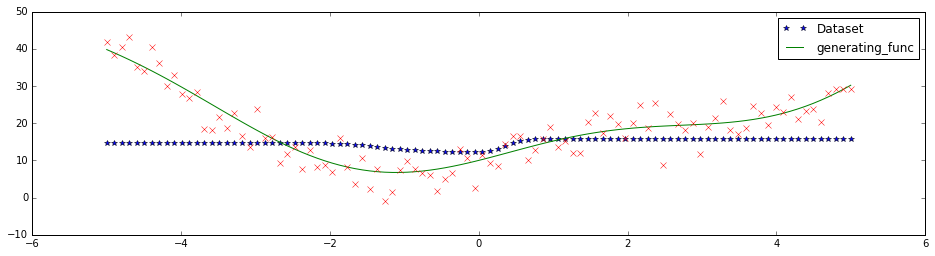

RSME is 9.694951057434082


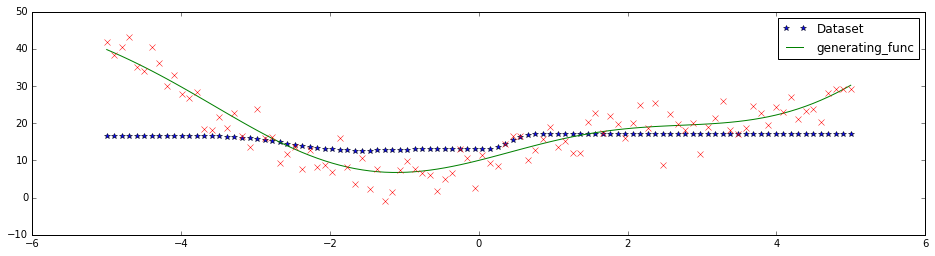

RSME is 8.824014663696289


In [18]:
vanilla_errors = []
for i in range(num_eps):

    vanilla.train(X,y)
    if i%(num_eps/5) ==0:


        vanilla_preds = vanilla.predict(X)
        plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds)

# Dropout

In [19]:
from dropout import DropoutNetwork

In [ ]:
dropout = DropoutNetwork()

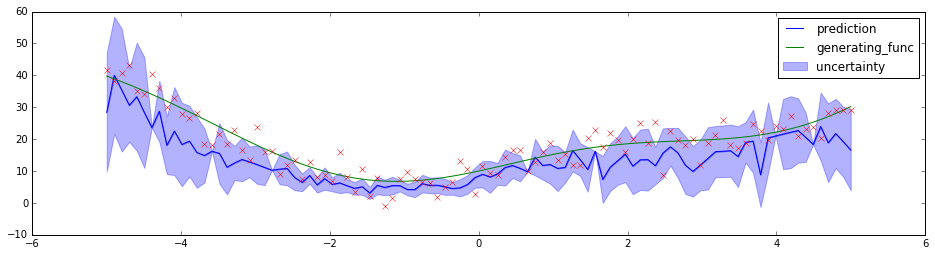

In [ ]:
errors = train_and_plot(dropout,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

# loop over experiment forever

In [ ]:

def plot_error_tmp(error_list, variance_list=False):
    if len(variance_list) > 0:
        diff = error_list - variance_list
        sum_ = error_list + variance_list
        X = np.linspace(0, len(error_list), len(error_list))
        plt.plot()
        plt.xlim = 50
        plt.fill_between(X, error_list, diff, alpha=.3,
                         color='b')
        plt.fill_between(X, error_list, sum_, alpha=.3,
                         color='b')
        #plt.plot(X,error_list)
        plt.xlim = 50
        plt.show()

        
    else:
        plt.plot(np.squeeze(error_list))
        
        
def plottt(error_list):
    plt.plot(np.squeeze(error_list))

In [ ]:
import numpy as np
n_samples = 20
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


bad_seeds = [2,4,10,13,15,16,9]
very_bad_seeds = [16,10]
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp = GaussianLossEstimator(**params)

    errors = train_and_plot(gauss_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

In [ ]:
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

In [ ]:
#for i in range(n_samples):
#    plt.plot(errors_meta[i])
#    plt.show()
#    print(i)

In [ ]:
import numpy as np

#num_epochs = 15#10
#num_eps = 25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta_lr = []


bad_seeds = [2,4]
for i in range(n_samples):
    silent = False
    if i == n_samples:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        params['seed'] = seed + 100+i
    lr_tmp = GaussianLearningRateEstimator(**params)

    errors = train_and_plot(lr_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta_lr.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta_lr,axis=0).flatten(),np.std(errors_meta_lr,axis=0).flatten())

In [ ]:
plot_error_tmp(np.mean(errors_meta_lr,axis=0).flatten(),np.std(errors_meta_lr,axis=0).flatten())

In [ ]:
plt.plot(errors_meta_lr[19])

### Example of bad seed
As we can see, the GaussianLossEstimator does not cope well with bad initialisations; as soon as the learning rate is being changed, it seems that (at least for the initialisations that should be equally problematic), the issue disappears. No clue why. Points towards initialisation scheme having a big-ish impact 

In [ ]:
import numpy as np
n_samples = 3
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


#bad_seeds = [2,4,10,13,15,16,9]
#very_bad_seeds = [16,10]
bad_seeds = [1,3]#ignoring the good seeds
very_bad_seeds = []
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp = GaussianLossEstimator(**params)

    errors = train_and_plot(gauss_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

In [ ]:
import numpy as np
n_samples = 3
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


#bad_seeds = [2,4,10,13,15,16,9]
#very_bad_seeds = [16,10]
bad_seeds = [1,3]#ignoring the good seeds
very_bad_seeds = []
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp_lr = GaussianLearningRateEstimator(**params)

    errors = train_and_plot(gauss_tmp_lr,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

# Old Stuff can probbly be removed only staying for security reasons

In [ ]:
gauss.train(X,y)
gauss_lr.train(X,y)
vanilla.train(X,y)

In [ ]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)

lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

In [ ]:
plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [ ]:
plot_prediction(X,lr_preds,sorted_index,lr_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [ ]:
plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [ ]:
evaluate_model(X,y,gauss_preds,var=gauss_var)

In [ ]:
evaluate_model(X,y,lr_preds,var=lr_var)

In [ ]:
evaluate_model(X,y,vanilla_preds)

# Other research
https://arxiv.org/pdf/1406.2541.pdf

https://arxiv.org/pdf/1612.01474.pdf